In [1]:
import numpy as np
import cv2
import glob
import json
import dlib
from imutils import face_utils
from sklearn import svm
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.decomposition import PCA, IncrementalPCA
import matplotlib.pyplot as plt
from tqdm import tqdm,trange
from IPython.display import HTML
from sklearn.metrics import auc
from sklearn.metrics import plot_roc_curve
from scipy import interp

# Custom Imports
from common_functions import generate_HTML_CM

In [2]:
# Load the dataset
with open('data_cleaned.json') as json_file:
    data_all = json.load(json_file)
# Extract the keys in sorted order
keys_all = sorted(data_all)
# Convert python list to np array
keys_all = np.asarray(keys_all)
participants = glob.glob('dataset/*')

In [3]:
### Uncomment to Use PCA for dimensionality reduction
# # features_all_scaled = ((features_all - features_all.mean(axis=0))/features_all.std(axis=0))

# n_comp = 32
# pca = PCA(n_components=n_comp)
# pca.fit(encodings_all)

# # ipca = IncrementalPCA(n_components=n_comp)
# # ipca.fit(features_all_scaled)

In [4]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

In [5]:
# Define global variables
NUM_OF_PARTICIPANTS = len(participants)

In [8]:
with open('uuid_lengths_128.json') as json_file:
    uuid_lengths = json.load(json_file)

uuids = []
sum = 0
for i in range(NUM_OF_PARTICIPANTS):
    uuid = participants[i].split('/')[1]
    uuids.append(uuid)
    # Μέσα στα lenghts έχει πόσα predictions έχει per participant
    # Οπότε στο τέλος τα uuids θα είναι η πρόσθεση τους
    sum += uuid_lengths[uuid]
DATASET_SIZE = sum
print(DATASET_SIZE)

2611


### Leave-one-out Evaluation


 25%|██▌       | 13/52 [01:18<03:43,  5.73s/it]

[[17  0]
 [31  0]]
[[17  0]
 [31  0]]
149797134bae4deaac692a73bf162fe9
------ LOW SCORE --------
------- UUID: 149797134bae4deaac692a73bf162fe9 -------
------- Samples for this subject: 48 -------



 35%|███▍      | 18/52 [01:46<03:11,  5.64s/it]

[[21  5]
 [21  3]]
[[26  0]
 [24  0]]
cebaaf0546e94fcb96c1a186838a73af



 46%|████▌     | 24/52 [02:21<02:40,  5.74s/it]

[[4 0]
 [9 0]]
[[4 0]
 [4 5]]
7d9be1d9b22e4a229b71dbf12f339243



 87%|████████▋ | 45/52 [04:32<00:39,  5.70s/it]

--- Detected Biased Object Filtering ---
--- Object's UUID: a50942013ca04ebdb2f9b172ca373f2c
--- Detected Biased Object Filtering ---
--- Object's UUID: 744055ae2e9e4d379108bbdbfab4dae5



 96%|█████████▌| 50/52 [04:49<00:10,  5.07s/it]

[[13  0]
 [42  0]]
[[13  0]
 [41  1]]
d456335e901547d78d5a11e14155353f
------ LOW SCORE --------
------- UUID: d456335e901547d78d5a11e14155353f -------
------- Samples for this subject: 55 -------



100%|██████████| 52/52 [05:00<00:00,  5.29s/it]

Total Accuracy RF:  29.96153846153846
Total Accucary SVM: 32.90384615384615
Precision RF: 0.6297505856308152
Precision SVM: 0.6613481832414734


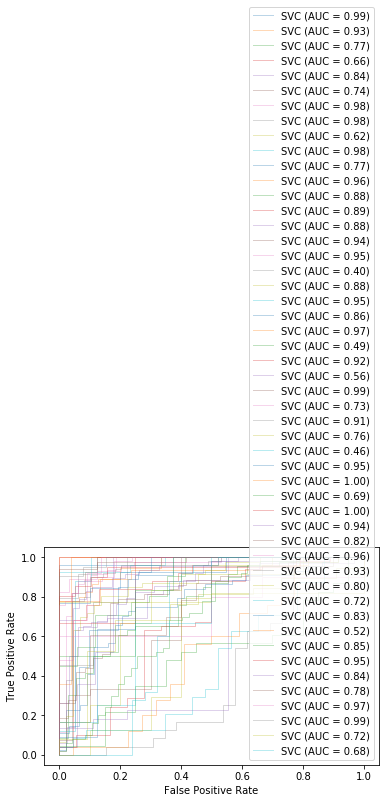

In [37]:
# Accuracy metrics for the whole dataset. These are computed
# by leaving every Subject out one time, calculating the accuracy for each
# one and then taking the mean value.
accuracy_rf_total = 0
accuracy_svm_total = 0
precision_rf = 0
precision_svm = 0

num_features = 128

# Calculate AVG metrics
Confusion_Matrix_SVM = []
Confusion_Matrix_RF = []

# avg ROC creation
fig, ax = plt.subplots()
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

# Keep Individual Accuracies for Gaussian Distribution Test
# And check if median if the proper metric for evaluation
# due to limited dataset size
accuracies = []
weightedAccuracies = []

# Loop over each participant
# for j in range(len(participants)):
for j in trange(len(participants)):
# for j in trange(10):
    # Extract the UUID
    uuid_excluded = uuids[j]
#     uuid_excluded = uuids[j]
    length_excluded = uuid_lengths[uuid_excluded]
    
    features_train = np.zeros((DATASET_SIZE  - length_excluded, num_features))
    features_val = np.zeros((length_excluded, num_features))
    labels_train = np.zeros(DATASET_SIZE - length_excluded)
    labels_val = np.zeros(length_excluded)
    
    start = 0
        
    for i in range(NUM_OF_PARTICIPANTS):
        uuid = uuids[i]
        length = uuid_lengths[uuid]

        features = np.load('encodings_128/encodings_' + uuid + '.npy')
        labels = np.load('encodings_128/labels_' + uuid + '.npy')
        # Filtering out subjects with the same only one class
        if (np.all(labels == labels[0])): continue
        
#         features = pca.transform(features)
        if uuid == uuid_excluded:
            if features.shape[0] != length:
                print('Error')
            features_val = features
            labels_val = labels
        else:
            if features.shape[0] != length:
                print('Error 2')
                print(features.shape[0], length, j, i)
                break
            features_train[start : start + length] = features
            labels_train[start : start + length] = labels
            start += length
    # Here I check if the validation classes are all in one class
    if not np.count_nonzero(features_val):
        print("--- Detected Biased Object Filtering ---")
        print("--- Object's UUID: {}".format(uuid_excluded))
        DATASET_LENGTH -= 1
        continue
    
    classifier = svm.SVC(C=10, kernel='rbf', gamma='scale', probability=True)
    classifier.fit(features_train, labels_train)
    
    # Predict SVM with threshold at 0.3 instead of 0.5
    threshold = 0.3
#     threshold = 0.5
    y_prob_svm = classifier.predict_proba(features_val)
    y_pred_svm = (y_prob_svm[:, 1] >= threshold).astype(int)
    

    rf_classifier = RandomForestClassifier(n_estimators=100, random_state=1)
    rf_classifier.fit(features_train, labels_train)
    y_pred_rf = rf_classifier.predict(features_val)
    
    # ROC metrics
    viz = plot_roc_curve(classifier, features_val, labels_val,
                         alpha=0.3, lw=1, ax=ax)  

    interp_tpr = interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

    confusion_matrix_svm = metrics.confusion_matrix(labels_val, y_pred_svm)
    confusion_matrix_rf = metrics.confusion_matrix(labels_val, y_pred_rf)
    Confusion_Matrix_SVM.append(confusion_matrix_svm)
    Confusion_Matrix_RF.append(confusion_matrix_rf)
    
    
    accuracy_svm_subject = metrics.accuracy_score(labels_val, y_pred_svm)
    accuracy_rf_subject = metrics.accuracy_score(labels_val, y_pred_rf)
    try:
        if confusion_matrix_rf[1][1] and confusion_matrix_svm[1][1]:
            precision_rf += confusion_matrix_rf[1][1]/(confusion_matrix_rf[1][1] + confusion_matrix_rf[0][1])
            precision_svm += confusion_matrix_svm[1][1]/(confusion_matrix_svm[1][1] + confusion_matrix_svm[0][1])
        else:
            print(confusion_matrix_rf)
            print(confusion_matrix_svm)
            print(uuid_excluded)
    except:
        print("--------- Broke ---------")
        print(features_val)
        print(labels_train)
        print(labels_val)
        print(uuid_excluded)
        
        
    # Here I add with this way the total accuracy to have a weight
    # The weight is the number or samples of it's subject
    accuracy_svm_total += accuracy_svm_subject*y_pred_svm.shape[0]
    accuracy_rf_total += accuracy_rf_subject*y_pred_rf.shape[0]
    accuracies.append(accuracy_svm_subject)
    weightedAccuracies.append(accuracy_svm_subject*y_pred_svm.shape[0])
    if(accuracy_svm_subject<0.4):
        print("------ LOW SCORE --------")
        print(("------- UUID: {} -------").format(uuid_excluded))
        print(("------- Samples for this subject: {} -------").format(y_pred_svm.shape[0]))
    

#     plot_learning_curve(classifier,'Learning Curve',  features_train, labels_train, cv=5)
#     plt.show()
print('Total Accuracy RF:  {}'.format(accuracy_rf_total/NUM_OF_PARTICIPANTS))
print('Total Accucary SVM: {}'.format(accuracy_svm_total/NUM_OF_PARTICIPANTS))
print('Precision RF: {}'.format(precision_rf/NUM_OF_PARTICIPANTS))
print('Precision SVM: {}'.format(precision_svm/NUM_OF_PARTICIPANTS))

In [15]:
print('Total Accuracy RF:  {}'.format(accuracy_rf_total/DATASET_SIZE))
print('Total Accucary SVM: {}'.format(accuracy_svm_total/DATASET_SIZE))
print('Precision RF: {}'.format(precision_rf/NUM_OF_PARTICIPANTS))
print('Precision SVM: {}'.format(precision_svm/NUM_OF_PARTICIPANTS))

Total Accuracy RF:  0.5967062428188433
Total Accucary SVM: 0.6568364611260054
Precision RF: 0.6297505856308152
Precision SVM: 0.6641728439694071


In [16]:
print("----- SVM Confusion Matrix ------")
h = HTML(generate_HTML_CM(Confusion_Matrix_SVM))
display(h)

print("----- Random Forest Confusion Matrix ------")
h = HTML(generate_HTML_CM(Confusion_Matrix_RF))
display(h)

----- SVM Confusion Matrix ------


----- Random Forest Confusion Matrix ------


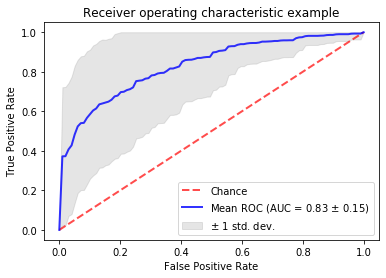

In [17]:
# %matplotlib notebook
fig, ax = plt.subplots()
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.7)

mean_tpr = np.nanmean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.nanstd(aucs)

ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

std_tpr = np.nanstd(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="Receiver operating characteristic example")
ax.legend(loc="lower right")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

In [36]:
testing = np.array(accuracies)
testing[testing<0.4]

array([0.35416667, 0.25454545])

p = 0.602121
The null hypothesis cannot be rejected
0.6672391454877584
0.6846506300114548
34.3
32.0


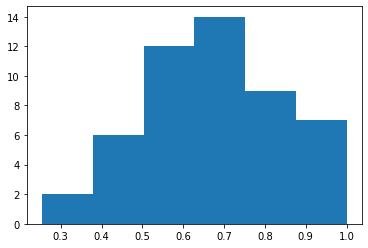

In [31]:
from scipy import stats
k2, p = stats.normaltest(accuracies)
alpha = 1e-3
print("p = {:g}".format(p))
if p < alpha:  # null hypothesis: x comes from a normal distribution
    print("The null hypothesis can be rejected")
else:
    print("The null hypothesis cannot be rejected")
    
print(np.mean(accuracies))
print(np.median(accuracies))
print(np.mean(weightedAccuracies))
print(np.median(weightedAccuracies))

plt.hist(accuracies, bins = 6)
plt.show()